# Progress Report
#### Petar Penev and Nicholas Kovacs

This is a progress report for the class project in CS 7280. Data for atomic interactions for the structure of the large subunit of the ribosome of the bacteria Thermus thermophilus were generated using the software arpeggio. This software calculates many different atomic interactions, but we only really care about are hydrogen bond, Van der Waals, polar, aromatic, hydrophobic, and ionic. The covalent interactions found with the arpeggio program are for inter-residue covalent interactions, which are practically non-existant in the ribosome. We will have to generate this data ourselves, probably through biopython.

Below is how the data was cleaned to produce a dataframe with relevant atomic, residue, chain, and interaction data, using the python package pandas. These dataframes work exceptionally well with networkx as, as networkx has functions that convert graphs to/from pandas adjacency matrices and edgelists. I have generated dataframes that can be inported into networkx as edgelists.

I use the python modules pandas, numpy, and biopython.PDB to clean the data from arpeggio

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 30)

import numpy as np
import networkx as nx
from Bio.PDB import *
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
%matplotlib inline
from IPython.display import Image

Here, I import the atomic interaction data from arpeggio into 6 dataframes, one dataframe for each phase of rRNA interaction. Each dataset contains interactions within rProteins, between rProteins, within rRNA, and between rRNA and rProtein.

In [2]:
phase1 = pd.read_csv("../Arpeggio_output/rRNA_phases_all_rPro/TT_LSUPhase1/LSU_Phase1_rRNA_all_rPro.contacts", sep='\t', 
                     names=['Atom1_id','Atom2_id','Clash','Covalent','VdW_Clash','VdW','Proximal',
                            'Hydrogen_Bond','Weak_Hydrogen_Bond','Halogen_Bond','Ionic',
                            'Metal_Complex','Aromatic','Hydrophobic','Carbonyl','Polar',
                            'Weak Polar','Interacting_entities'])
phase1['Phase'] = '1'

phase2 = pd.read_csv("../Arpeggio_output/rRNA_phases_all_rPro/TT_LSUPhase2/LSU_Phase2_rRNA_all_rPro.contacts", sep='\t', 
                     names=['Atom1_id','Atom2_id','Clash','Covalent','VdW_Clash','VdW','Proximal',
                            'Hydrogen_Bond','Weak_Hydrogen_Bond','Halogen_Bond','Ionic',
                            'Metal_Complex','Aromatic','Hydrophobic','Carbonyl','Polar',
                            'Weak Polar','Interacting_entities'])
phase2['Phase'] = '2'

phase3 = pd.read_csv("../Arpeggio_output/rRNA_phases_all_rPro/TT_LSUPhase3/LSU_Phase3_rRNA_all_rPro.contacts", sep='\t', 
                     names=['Atom1_id','Atom2_id','Clash','Covalent','VdW_Clash','VdW','Proximal',
                            'Hydrogen_Bond','Weak_Hydrogen_Bond','Halogen_Bond','Ionic',
                            'Metal_Complex','Aromatic','Hydrophobic','Carbonyl','Polar',
                            'Weak Polar','Interacting_entities'])
phase3['Phase'] = '3'

phase4 = pd.read_csv("../Arpeggio_output/rRNA_phases_all_rPro/TT_LSUPhase4/LSU_Phase4_rRNA_all_rPro.contacts", sep='\t', 
                     names=['Atom1_id','Atom2_id','Clash','Covalent','VdW_Clash','VdW','Proximal',
                            'Hydrogen_Bond','Weak_Hydrogen_Bond','Halogen_Bond','Ionic',
                            'Metal_Complex','Aromatic','Hydrophobic','Carbonyl','Polar',
                            'Weak Polar','Interacting_entities'])
phase4['Phase'] = '4'

phase5 = pd.read_csv("../Arpeggio_output/rRNA_phases_all_rPro/TT_LSUPhase5/LSU_Phase5_rRNA_all_rPro.contacts", sep='\t', 
                     names=['Atom1_id','Atom2_id','Clash','Covalent','VdW_Clash','VdW','Proximal',
                            'Hydrogen_Bond','Weak_Hydrogen_Bond','Halogen_Bond','Ionic',
                            'Metal_Complex','Aromatic','Hydrophobic','Carbonyl','Polar',
                            'Weak Polar','Interacting_entities'])
phase5['Phase'] = '5'

phase6 = pd.read_csv("../Arpeggio_output/rRNA_phases_all_rPro/TT_LSUPhase6/LSU_Phase6_rRNA_all_rPro.contacts", sep='\t', 
                     names=['Atom1_id','Atom2_id','Clash','Covalent','VdW_Clash','VdW','Proximal',
                            'Hydrogen_Bond','Weak_Hydrogen_Bond','Halogen_Bond','Ionic',
                            'Metal_Complex','Aromatic','Hydrophobic','Carbonyl','Polar',
                            'Weak Polar','Interacting_entities'])
phase6['Phase'] = '6'

The 6 dataframes are merged into one, all duplicate interactions are removed, and then the dataframe is divided back into 6 dataframes corresponding to which Phase the interactions belong. This step is done to remove interactions within and between the rProteins that are not unique to the rRNA phase. The focus of this project is on interactions that involve rRNA evolutionary phases. 

In [3]:
all_phases = pd.concat([phase1,phase2,phase3,phase4,phase5,phase6])
all_phases = all_phases.drop_duplicates(all_phases.columns.difference(['Phase']), keep=False)
all_phases[['chain1', 'resnum1', 'atom1']] = all_phases['Atom1_id'].str.split('/', expand=True)
all_phases[['chain2', 'resnum2', 'atom2']] = all_phases['Atom2_id'].str.split('/', expand=True)

The strucutral bioinformatics biopython module is used to import a structure of our PDB

In [163]:
parser = PDBParser(QUIET=True)
ThTh_PDB = parser.get_structure('ThTh_PDB', '../TT_Phases_PDB/1VY4_LSU_rRNA+rProtein.pdb')

In [5]:
def make_PDB_df(parsed_structure):
    """
    Create BioPython List of atom properties 
    """
    structure_list = []
    for atom in Selection.unfold_entities(parsed_structure, 'A'):
        atom_name = str(atom.id)
        resnum = str(atom.get_parent().id[1])
        resname = str(atom.get_parent().resname)
        chain = str(atom.get_parent().get_parent().id)
        structure_list.append([chain, resnum, atom_name, resname, atom.coord[0], atom.coord[1], atom.coord[2]])
    structure_df = pd.DataFrame(structure_list, columns=['chain1', 'resnum1', 'atom1', 'resname1', 'x1', 'y1', 'z1'])
    return(structure_df)

In [162]:
def add_atom_info(df, structure_df):
    """
    Add resname, x, y, z to both atoms in dataframe row
    """
    df = pd.merge(df, structure_df, on=['chain1','resnum1','atom1'])
    structure_df_temp = structure_df.rename(columns={'chain1':'chain2', 'resnum1':'resnum2', 'atom1':'atom2', 'resname1':'resname2', 'x1':'x2', 'y1':'y2', 'z1':'z2'})
    df = pd.merge(df, structure_df_temp, on=['chain2','resnum2','atom2'])
    return(df)

In [7]:
def add_polymer_name_col(df):
    """
    Add polymer name of both atoms to the dataframe
    """
    name_chains1 = pd.read_csv('../standards/name_chains.csv', names=['name1', 'chain1'])
    name_chains2 = pd.read_csv('../standards/name_chains.csv', names=['name2', 'chain2'])
    df = pd.merge(df, name_chains1).merge(name_chains2)
    return(df)

In [30]:
def remove_irrelevant_col_rows(df):
    """
    Remove irrelevant col and then remove the rows that then do not have any bonds
    """
    df = df[(df.Hydrogen_Bond == 1) | (df.VdW == 1) | (df.Polar == 1) | (df.Aromatic == 1) | (df.Hydrophobic == 1) | (df.Ionic == 1)]
    df = df[['Phase', 'x1', 'y1', 'z1', 'Atom1_id', 'resname1', 'atom1', 'resnum1', 'name1', 'Hydrogen_Bond', 'VdW', 'Polar', 'Aromatic', 'Hydrophobic', 'Ionic', 'resname2', 'atom2', 'resnum2', 'name2', 'Atom2_id', 'x2', 'y2', 'z2']]
    return(df)

In [31]:
def clean_df(df, parsed_structure):
    
    structure_df = make_PDB_df(parsed_structure)
    df = add_atom_info(df, structure_df)
    df = add_polymer_name_col(df)
    df = remove_irrelevant_col_rows(df)    
    
    return(df)

In [32]:
all_relevant = clean_df(all_phases, ThTh_PDB)

Now divide the dataframe into 6 phases

In [33]:
P1 = all_relevant.loc[all_relevant['Phase'] == '1'].drop(['Phase'], axis=1)
P2 = all_relevant.loc[all_relevant['Phase'] == '2'].drop(['Phase'], axis=1)
P3 = all_relevant.loc[all_relevant['Phase'] == '3'].drop(['Phase'], axis=1)
P4 = all_relevant.loc[all_relevant['Phase'] == '4'].drop(['Phase'], axis=1)
P5 = all_relevant.loc[all_relevant['Phase'] == '5'].drop(['Phase'], axis=1)
P6 = all_relevant.loc[all_relevant['Phase'] == '6'].drop(['Phase'], axis=1)

Here, dataframes are created that involve interactions only with the rRNA

In [34]:
P1_PRI = P1[(P1.name1 == '23S') | (P1.name2 == '23S') | (P1.name1 == '5S') | (P1.name2 == '5S')].query('name1 != name2')
P2_PRI = P2[(P2.name1 == '23S') | (P2.name2 == '23S') | (P2.name1 == '5S') | (P2.name2 == '5S')].query('name1 != name2')
P3_PRI = P3[(P3.name1 == '23S') | (P3.name2 == '23S') | (P3.name1 == '5S') | (P3.name2 == '5S')].query('name1 != name2')
P4_PRI = P4[(P4.name1 == '23S') | (P4.name2 == '23S') | (P4.name1 == '5S') | (P4.name2 == '5S')].query('name1 != name2')
P5_PRI = P5[(P5.name1 == '23S') | (P5.name2 == '23S') | (P5.name1 == '5S') | (P5.name2 == '5S')].query('name1 != name2')
P6_PRI = P6[(P6.name1 == '23S') | (P6.name2 == '23S') | (P6.name1 == '5S') | (P6.name2 == '5S')].query('name1 != name2')

Here is a sample of the unique, atomic interactions between rRNA and rProtein of the 6th phase of ribosomal evolution:

In [35]:
P1_PRI

,x1,y1,z1,Atom1_id,resname1,atom1,resnum1,name1,Hydrogen_Bond,VdW,Polar,Aromatic,Hydrophobic,Ionic,resname2,atom2,resnum2,name2,Atom2_id,x2,y2,z2
4398,-40.660000,144.022995,171.328995,F/74/NH2,ARG,NH2,74,uL04,1,0,1,0,0,1,G,OP1,2445,23S,A/2445/OP1,-42.754002,144.257004,170.166000
4399,-39.756001,144.785995,171.908005,F/74/CZ,ARG,CZ,74,uL04,0,0,0,0,0,1,G,OP1,2445,23S,A/2445/OP1,-42.754002,144.257004,170.166000
4400,-40.143002,145.856003,172.578003,F/74/NH1,ARG,NH1,74,uL04,0,0,0,0,0,1,G,OP1,2445,23S,A/2445/OP1,-42.754002,144.257004,170.166000
4405,-37.841999,138.794998,166.824997,F/68/NZ,LYS,NZ,68,uL04,1,1,1,0,0,0,G,OP1,2061,23S,A/2061/OP1,-39.466000,136.162994,166.899002
4412,-35.984001,139.516006,165.371002,F/68/CD,LYS,CD,68,uL04,0,1,0,0,0,0,G,OP2,2444,23S,A/2444/OP2,-38.988998,140.891998,165.470993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457549,-65.106003,120.750999,153.306000,A/2494/O2',G,O2',2494,23S,0,0,1,0,0,0,GLU,O,80,uL16,Q/80/O,-65.144997,122.790001,150.653000
457594,-91.415001,98.468002,156.496002,A/2467/C4',C,C4',2467,23S,0,1,0,0,0,0,HIS,CE1,123,uL16,Q/123/CE1,-92.973000,100.526001,158.854996
457603,-90.315002,99.320000,156.089996,A/2467/O4',C,O4',2467,23S,0,0,1,0,0,0,HIS,ND1,123,uL16,Q/123/ND1,-92.319000,101.263000,157.977005
457606,-91.415001,98.468002,156.496002,A/2467/C4',C,C4',2467,23S,0,1,0,0,0,0,HIS,ND1,123,uL16,Q/123/ND1,-92.319000,101.263000,157.977005


Here is an analysis of the number of residues and their interactions between rRNA and rProtein in Phase 1. Amino acid residues have 3 letter codes, nucleic acid residues have 1 letter codes.

In [36]:
P1_PRI.groupby(["resname1", "resname2"]).size().reset_index(name="Occurances")

,resname1,resname2,Occurances
0,A,ARG,2
1,A,LYS,1
2,C,ARG,1
3,C,GLN,1
4,C,HIS,4
...,...,...,...
38,MET,C,1
39,PRO,G,2
40,SER,C,1
41,TYR,C,1


We are confident that if we continue massaging the data and looking at it from different perspectives, that we will find interesting patterns. We would like to explore:
- secondary structures of rProtein and rRNA
- compare interactions within rRNA, or rProtein, or between rRNA and rProtein
- look at centrality measures of atoms, residues, secondary structures, rProtein, rRNA
- rRNA-rProtein interface network comparisons
- evolutionary phase interface network comparisons
- and perhaps new metrics and ideas brought up in future lectures

In [37]:
P1_PRI

,x1,y1,z1,Atom1_id,resname1,atom1,resnum1,name1,Hydrogen_Bond,VdW,Polar,Aromatic,Hydrophobic,Ionic,resname2,atom2,resnum2,name2,Atom2_id,x2,y2,z2
4398,-40.660000,144.022995,171.328995,F/74/NH2,ARG,NH2,74,uL04,1,0,1,0,0,1,G,OP1,2445,23S,A/2445/OP1,-42.754002,144.257004,170.166000
4399,-39.756001,144.785995,171.908005,F/74/CZ,ARG,CZ,74,uL04,0,0,0,0,0,1,G,OP1,2445,23S,A/2445/OP1,-42.754002,144.257004,170.166000
4400,-40.143002,145.856003,172.578003,F/74/NH1,ARG,NH1,74,uL04,0,0,0,0,0,1,G,OP1,2445,23S,A/2445/OP1,-42.754002,144.257004,170.166000
4405,-37.841999,138.794998,166.824997,F/68/NZ,LYS,NZ,68,uL04,1,1,1,0,0,0,G,OP1,2061,23S,A/2061/OP1,-39.466000,136.162994,166.899002
4412,-35.984001,139.516006,165.371002,F/68/CD,LYS,CD,68,uL04,0,1,0,0,0,0,G,OP2,2444,23S,A/2444/OP2,-38.988998,140.891998,165.470993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457549,-65.106003,120.750999,153.306000,A/2494/O2',G,O2',2494,23S,0,0,1,0,0,0,GLU,O,80,uL16,Q/80/O,-65.144997,122.790001,150.653000
457594,-91.415001,98.468002,156.496002,A/2467/C4',C,C4',2467,23S,0,1,0,0,0,0,HIS,CE1,123,uL16,Q/123/CE1,-92.973000,100.526001,158.854996
457603,-90.315002,99.320000,156.089996,A/2467/O4',C,O4',2467,23S,0,0,1,0,0,0,HIS,ND1,123,uL16,Q/123/ND1,-92.319000,101.263000,157.977005
457606,-91.415001,98.468002,156.496002,A/2467/C4',C,C4',2467,23S,0,1,0,0,0,0,HIS,ND1,123,uL16,Q/123/ND1,-92.319000,101.263000,157.977005


In [125]:
def plot_nodes_edges(df):    
    df_x_edges = df[['x1', 'x2']].copy()
    df_x_edges['None'] = 'None'
    df_y_edges = df[['y1', 'y2']].copy()
    df_y_edges['None'] = 'None'
    df_z_edges = df[['z1', 'z2']].copy()
    df_z_edges['None'] = 'None'

    trace1 = go.Scatter3d(
            x = df['x1'],
            y = df['y1'],
            z = df['z1'],
            text = df['resname1']+' '+df['atom1']+' '+df['resnum1']+' '+df['name1'],
            mode = 'markers'
            )

    trace2 = go.Scatter3d(
            x = df['x2'],
            y = df['y2'],
            z = df['z2'],
            text = df['resname2']+' '+df['atom2']+' '+df['resnum2']+' '+df['name2'],
            mode = 'markers'
            )

    trace3 = go.Scatter3d(
            x = df_x_edges.values.flatten(),
            y = df_y_edges.values.flatten(),
            z = df_z_edges.values.flatten(),
            mode = 'lines',
            hoverinfo = 'none'
            )

    layout = go.Layout(
        title = 'Atomic Interactions',
        showlegend = True
    )

    data=go.Data([trace1, trace2, trace3])
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [126]:
plot_nodes_edges(P1_PRI)

In [127]:
plot_nodes_edges(P3)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [128]:
all_phases

,Atom1_id,Atom2_id,Clash,Covalent,VdW_Clash,VdW,Proximal,Hydrogen_Bond,Weak_Hydrogen_Bond,Halogen_Bond,Ionic,Metal_Complex,Aromatic,Hydrophobic,Carbonyl,Polar,Weak Polar,Interacting_entities,Phase,chain1,resnum1,atom1,chain2,resnum2,atom2
137,P/2/CD,P/4/N,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,1,P,2,CD,P,4,N
310,F/106/CD,F/101/CB,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,1,F,106,CD,F,101,CB
311,F/106/CD,F/101/CA,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,1,F,106,CD,F,101,CA
312,F/106/CD,F/101/C,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,1,F,106,CD,F,101,C
331,F/106/CD,F/102/N,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,1,F,106,CD,F,102,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238860,4/67/O,4/65/C,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,6,4,67,O,4,65,C
238862,4/69/CE,4/502/MG,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,6,4,69,CE,4,502,MG
238863,4/69/NZ,4/502/MG,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,6,4,69,NZ,4,502,MG
238864,4/69/CD,4/502/MG,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,6,4,69,CD,4,502,MG


In [129]:
phases = pd.concat([phase1,phase2,phase3,phase4,phase5,phase6])
phases = phases.drop_duplicates(phases.columns.difference(['Phase']), keep='first')
phases[['chain1', 'resnum1', 'atom1']] = phases['Atom1_id'].str.split('/', expand=True)
phases[['chain2', 'resnum2', 'atom2']] = phases['Atom2_id'].str.split('/', expand=True)

In [130]:
phases = clean_df(phases, ThTh_PDB)

In [131]:
phases = phases.drop('Phase', 1)

In [132]:
phases

,x1,y1,z1,Atom1_id,resname1,atom1,resnum1,name1,Hydrogen_Bond,VdW,Polar,Aromatic,Hydrophobic,Ionic,resname2,atom2,resnum2,name2,Atom2_id,x2,y2,z2
17,-42.365002,213.417999,220.283997,F/16/O,GLY,O,16,uL04,0,0,1,0,0,0,ARG,N,18,uL04,F/18/N,-45.000999,212.112000,219.585007
18,-43.347000,210.309006,218.332993,F/11/O,VAL,O,11,uL04,1,0,1,0,0,0,ARG,N,18,uL04,F/18/N,-45.000999,212.112000,219.585007
26,-42.365002,213.417999,220.283997,F/16/O,GLY,O,16,uL04,1,0,1,0,0,0,SER,N,13,uL04,F/13/N,-39.932999,211.850006,218.733002
51,-45.000999,212.112000,219.585007,F/18/N,ARG,N,18,uL04,1,0,1,0,0,0,VAL,O,11,uL04,F/11/O,-43.347000,210.309006,218.332993
62,-44.257000,210.651993,215.337006,F/11/CB,VAL,CB,11,uL04,0,0,0,0,1,0,ARG,CB,18,uL04,F/18/CB,-45.287998,213.395996,217.522995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681115,-128.253006,143.306000,94.825996,G/117/CE2,PHE,CE2,117,uL05,0,0,0,0,1,0,PHE,CD1,42,bL31,4/42/CD1,-131.533997,141.153000,93.935997
681120,-127.580002,142.932999,93.679001,G/117/CD2,PHE,CD2,117,uL05,0,0,0,0,1,0,PHE,CD1,42,bL31,4/42/CD1,-131.533997,141.153000,93.935997
681142,-128.317001,148.225998,90.413002,G/112/CB,PRO,CB,112,uL05,0,0,0,0,1,0,VAL,CG2,35,bL31,4/35/CG2,-128.619003,147.608994,86.112000
681161,-131.766006,144.067001,97.041000,G/179/CB,PRO,CB,179,uL05,0,0,0,0,1,0,PHE,CZ,42,bL31,4/42/CZ,-131.815994,139.746002,95.842003


Make PPI df

In [133]:
phases_PPI = phases[(phases.name1 != '23S') | (phases.name2 != '23S') | (phases.name1 != '5S') | (phases.name2 != '5S')]

In [134]:
phases_PPI

,x1,y1,z1,Atom1_id,resname1,atom1,resnum1,name1,Hydrogen_Bond,VdW,Polar,Aromatic,Hydrophobic,Ionic,resname2,atom2,resnum2,name2,Atom2_id,x2,y2,z2
17,-42.365002,213.417999,220.283997,F/16/O,GLY,O,16,uL04,0,0,1,0,0,0,ARG,N,18,uL04,F/18/N,-45.000999,212.112000,219.585007
18,-43.347000,210.309006,218.332993,F/11/O,VAL,O,11,uL04,1,0,1,0,0,0,ARG,N,18,uL04,F/18/N,-45.000999,212.112000,219.585007
26,-42.365002,213.417999,220.283997,F/16/O,GLY,O,16,uL04,1,0,1,0,0,0,SER,N,13,uL04,F/13/N,-39.932999,211.850006,218.733002
51,-45.000999,212.112000,219.585007,F/18/N,ARG,N,18,uL04,1,0,1,0,0,0,VAL,O,11,uL04,F/11/O,-43.347000,210.309006,218.332993
62,-44.257000,210.651993,215.337006,F/11/CB,VAL,CB,11,uL04,0,0,0,0,1,0,ARG,CB,18,uL04,F/18/CB,-45.287998,213.395996,217.522995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681115,-128.253006,143.306000,94.825996,G/117/CE2,PHE,CE2,117,uL05,0,0,0,0,1,0,PHE,CD1,42,bL31,4/42/CD1,-131.533997,141.153000,93.935997
681120,-127.580002,142.932999,93.679001,G/117/CD2,PHE,CD2,117,uL05,0,0,0,0,1,0,PHE,CD1,42,bL31,4/42/CD1,-131.533997,141.153000,93.935997
681142,-128.317001,148.225998,90.413002,G/112/CB,PRO,CB,112,uL05,0,0,0,0,1,0,VAL,CG2,35,bL31,4/35/CG2,-128.619003,147.608994,86.112000
681161,-131.766006,144.067001,97.041000,G/179/CB,PRO,CB,179,uL05,0,0,0,0,1,0,PHE,CZ,42,bL31,4/42/CZ,-131.815994,139.746002,95.842003


In [135]:
uL4 = phases[(phases.name1 == 'uL04') | (phases.name2 == 'uL04')]

In [136]:
uL4

,x1,y1,z1,Atom1_id,resname1,atom1,resnum1,name1,Hydrogen_Bond,VdW,Polar,Aromatic,Hydrophobic,Ionic,resname2,atom2,resnum2,name2,Atom2_id,x2,y2,z2
17,-42.365002,213.417999,220.283997,F/16/O,GLY,O,16,uL04,0,0,1,0,0,0,ARG,N,18,uL04,F/18/N,-45.000999,212.112000,219.585007
18,-43.347000,210.309006,218.332993,F/11/O,VAL,O,11,uL04,1,0,1,0,0,0,ARG,N,18,uL04,F/18/N,-45.000999,212.112000,219.585007
26,-42.365002,213.417999,220.283997,F/16/O,GLY,O,16,uL04,1,0,1,0,0,0,SER,N,13,uL04,F/13/N,-39.932999,211.850006,218.733002
51,-45.000999,212.112000,219.585007,F/18/N,ARG,N,18,uL04,1,0,1,0,0,0,VAL,O,11,uL04,F/11/O,-43.347000,210.309006,218.332993
62,-44.257000,210.651993,215.337006,F/11/CB,VAL,CB,11,uL04,0,0,0,0,1,0,ARG,CB,18,uL04,F/18/CB,-45.287998,213.395996,217.522995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26797,-22.451000,191.567993,214.072998,F/169/OD1,ASN,OD1,169,uL04,0,0,1,0,0,0,G,N2,323,23S,A/323/N2,-20.298000,190.257996,216.248993
26804,-22.908001,191.404007,211.891998,F/169/ND2,ASN,ND2,169,uL04,0,1,0,0,0,0,A,C3',322,23S,A/322/C3',-19.697001,191.108002,211.007996
26815,-22.908001,191.404007,211.891998,F/169/ND2,ASN,ND2,169,uL04,1,0,0,0,0,0,G,O5',323,23S,A/323/O5',-21.344000,188.554001,210.582001
26832,-44.910000,199.970001,185.373001,F/103/NZ,LYS,NZ,103,uL04,1,0,1,0,0,0,G,O6,619,23S,A/619/O6,-43.236000,197.436005,183.951004


In [137]:
plot_nodes_edges(uL4)

In [138]:
uL4_interaction = phases[(phases.name1 == 'uL04') | (phases.name2 == 'uL04')].query('name1 != name2')

In [139]:
plot_nodes_edges(uL4_interaction)

In [140]:
uL4

,x1,y1,z1,Atom1_id,resname1,atom1,resnum1,name1,Hydrogen_Bond,VdW,Polar,Aromatic,Hydrophobic,Ionic,resname2,atom2,resnum2,name2,Atom2_id,x2,y2,z2
17,-42.365002,213.417999,220.283997,F/16/O,GLY,O,16,uL04,0,0,1,0,0,0,ARG,N,18,uL04,F/18/N,-45.000999,212.112000,219.585007
18,-43.347000,210.309006,218.332993,F/11/O,VAL,O,11,uL04,1,0,1,0,0,0,ARG,N,18,uL04,F/18/N,-45.000999,212.112000,219.585007
26,-42.365002,213.417999,220.283997,F/16/O,GLY,O,16,uL04,1,0,1,0,0,0,SER,N,13,uL04,F/13/N,-39.932999,211.850006,218.733002
51,-45.000999,212.112000,219.585007,F/18/N,ARG,N,18,uL04,1,0,1,0,0,0,VAL,O,11,uL04,F/11/O,-43.347000,210.309006,218.332993
62,-44.257000,210.651993,215.337006,F/11/CB,VAL,CB,11,uL04,0,0,0,0,1,0,ARG,CB,18,uL04,F/18/CB,-45.287998,213.395996,217.522995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26797,-22.451000,191.567993,214.072998,F/169/OD1,ASN,OD1,169,uL04,0,0,1,0,0,0,G,N2,323,23S,A/323/N2,-20.298000,190.257996,216.248993
26804,-22.908001,191.404007,211.891998,F/169/ND2,ASN,ND2,169,uL04,0,1,0,0,0,0,A,C3',322,23S,A/322/C3',-19.697001,191.108002,211.007996
26815,-22.908001,191.404007,211.891998,F/169/ND2,ASN,ND2,169,uL04,1,0,0,0,0,0,G,O5',323,23S,A/323/O5',-21.344000,188.554001,210.582001
26832,-44.910000,199.970001,185.373001,F/103/NZ,LYS,NZ,103,uL04,1,0,1,0,0,0,G,O6,619,23S,A/619/O6,-43.236000,197.436005,183.951004


In [141]:
uL4_nx = nx.from_pandas_edgelist(uL4, source='Atom1_id', target='Atom2_id')

In [142]:
uL4_nx

In [143]:
uL4_G = nx.Graph(uL4_nx)

In [144]:
uL4_G

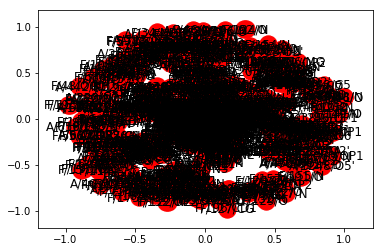

In [145]:
nx.draw_networkx(uL4_G)

In [200]:
def print_top5(metric):
    top5 = {key: metric[key] for key in sorted(metric, key=metric.get, reverse=True)[:5]}
    for x in top5:
        print(x, '\t', top5[x])

In [205]:
def print_centrality(graph):
    degree = nx.degree_centrality(graph)
    closeness = nx.closeness_centrality(graph)
    harmonic = nx.harmonic_centrality(graph)
    betweenness = nx.betweenness_centrality(graph)
    eigenvector = nx.eigenvector_centrality(graph, max_iter=1000)
    print('degree:')
    print_top5(degree)
    print('\ncloseness:')
    print_top5(closeness)
    print('\nharmonic:')
    print_top5(harmonic)
    print('\nbetweenness:')
    print_top5(betweenness)
    print('\neigenvector:')
    print_top5(eigenvector)

In [206]:
print_centrality(uL4_G)

degree:
F/163/CG1 	 0.010330578512396695
F/125/CD1 	 0.009297520661157025
F/202/CE1 	 0.009297520661157025
F/129/CD2 	 0.009297520661157025
F/142/CZ2 	 0.008264462809917356

closeness:
F/113/CB 	 0.04591958757407457
F/33/CD1 	 0.043429270356423286
F/186/CD1 	 0.043407269712879
F/183/CB 	 0.04325388713438826
F/186/CG2 	 0.04310158471490098

harmonic:
F/113/CB 	 62.19258086684577
F/194/CE 	 61.688198359947854
F/192/CD1 	 61.624838843647126
F/186/CD1 	 61.1550118569084
F/114/CG2 	 60.30541561981213

betweenness:
F/113/CB 	 0.04663200679415696
F/33/CD1 	 0.030575911655556516
F/36/CG1 	 0.02830997491349175
F/183/CB 	 0.0211737548718472
F/109/O 	 0.019293857686010902

eigenvector:
F/114/CG1 	 0.31353565881889917
F/199/CZ3 	 0.2885775215460439
F/194/CE 	 0.2799385507682867
F/202/CE2 	 0.2713359579934023
F/199/CH2 	 0.24658811473303877


In [207]:
def parse_df(df, parsed_structure):
    
    structure_df = make_PDB_df(parsed_structure)
    df = add_atom_info(df, structure_df)
    df = add_polymer_name_col(df)
    #df = remove_irrelevant_col_rows(df)    
    
    return(df)

In [208]:
all_phases

,Atom1_id,Atom2_id,Clash,Covalent,VdW_Clash,VdW,Proximal,Hydrogen_Bond,Weak_Hydrogen_Bond,Halogen_Bond,Ionic,Metal_Complex,Aromatic,Hydrophobic,Carbonyl,Polar,Weak Polar,Interacting_entities,Phase,chain1,resnum1,atom1,chain2,resnum2,atom2
137,P/2/CD,P/4/N,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,1,P,2,CD,P,4,N
310,F/106/CD,F/101/CB,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,1,F,106,CD,F,101,CB
311,F/106/CD,F/101/CA,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,1,F,106,CD,F,101,CA
312,F/106/CD,F/101/C,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,1,F,106,CD,F,101,C
331,F/106/CD,F/102/N,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,1,F,106,CD,F,102,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238860,4/67/O,4/65/C,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,6,4,67,O,4,65,C
238862,4/69/CE,4/502/MG,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,6,4,69,CE,4,502,MG
238863,4/69/NZ,4/502/MG,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,6,4,69,NZ,4,502,MG
238864,4/69/CD,4/502/MG,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,INTRA_SELECTION,6,4,69,CD,4,502,MG


In [209]:
test = all_phases.loc[all_phases['Phase'] == '1'].drop(['Phase'], axis=1)

In [210]:
test = parse_df(test, ThTh_PDB)

In [211]:
test_nx = nx.from_pandas_edgelist(test, source='Atom1_id', target='Atom2_id')

In [213]:
test_G = nx.Graph(test_nx)

In [214]:
print_centrality(test_G)

degree:
A/2481/N2 	 0.005559299191374664
A/2063/N4 	 0.005390835579514825
A/2444/N1 	 0.0052223719676549865
A/2459/N6 	 0.0052223719676549865
A/2460/O4 	 0.0052223719676549865

closeness:
A/2064/N1 	 0.04368784905695713
A/2450/N3 	 0.04328919069542549
A/2065/N3 	 0.043235837385668545
A/2065/C4 	 0.043226023485681525
A/2065/C2 	 0.043223220332509735

harmonic:
A/2446/N2 	 394.41484895466556
A/2065/N3 	 392.986370129906
A/2064/O2 	 391.91418518774776
A/2065/C2 	 390.74351298704886
A/2065/C4 	 390.56970346323925

betweenness:
0/2/CB 	 0.05471817342399631
A/2451/O5' 	 0.054655937038103015
A/2494/OP2 	 0.05214993473234507
A/2461/O2' 	 0.048413150600966
A/2073/OP2 	 0.04643494618779088

eigenvector:
A/2488/N1 	 0.15333724598962153
A/2488/C6 	 0.14815775334015088
A/2462/N3 	 0.14331043221548231
A/2489/C6 	 0.13811769945251942
A/2489/N1 	 0.13757880833997002
